In [1]:
# this notebook predicts the sentiments of tweets regarding the GOP presidential debate 2016
# data obtained from Crowdflower's "Data For Everyone" library: https://www.figure-eight.com/data-for-everyone/

In [2]:
%reset -f

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize

np.random.seed(123)

In [3]:
# import dataset
full = pd.read_csv('../data/GOP_presidential_debate_2016_tweets/Sentiment.csv')

# keep only relevant columns
full = full[['sentiment','text']]

# let's try binary classification for this project; drop tweets that have neutral sentiment
full = full.loc[(full['sentiment']!='Neutral'),]

# shuffle rows (we'll be splitting data into train and test sets later)
full = full.sample(frac=1)

Negative    79.159288
Positive    20.840712
Name: sentiment, dtype: float64


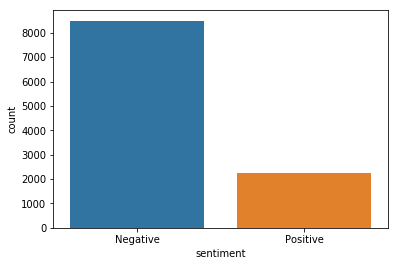

In [4]:
# plot frequencies of positive and negative tweets
sns.countplot(x='sentiment', data=full) # most tweets are negative
print(full['sentiment'].value_counts() / full.shape[0] * 100) # the baseline model's accuracy is 79%

In [5]:
# clean the tweets
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

full = full.reset_index(drop=True)

corpus = []

ps = PorterStemmer() # to convert each word into its root form (e.g. 'loved' to 'love')

for i in range(0, full.shape[0]):
    tweet = full['text'][i].lower() # convert all words to lowercase
    tweet = tweet.split() # split text into a list of individual words
    tweet = [ps.stem(word) for word in tweet if word not in set(stopwords.words('english'))] # remove stopwords (e.g. 'this', 'and')
    tweet = ' '.join(tweet) # join the words together, with a space between each word
    corpus.append(tweet)

In [6]:
# Create the Bag of Words model (i.e. a matrix where rows represent tweets, columns represent words, and cells represent word count)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x = cv.fit_transform(corpus).toarray()
y = full['sentiment'].values

In [7]:
# Split the dataset into the train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [8]:
# Fit adaboost to the train set
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier()
classifier.fit(x_train, y_train)

# check test accuracy
print('test accuracy is:', classifier.score(x_test,y_test)) # calculate accuracy

test accuracy is: 0.8434296365330848


In [9]:
##### use random search to optimize the hyperparameters, while building the optimal model concurrently
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'learning_rate': uniform(0.1,0.9),
              'n_estimators': randint(50,300)
             }

tune_model = RandomizedSearchCV(AdaBoostClassifier(),
                                param_distributions=param_dist,
                                scoring = 'accuracy',
                                cv = 5,
                                n_iter = 5) # number of iterations of random search

tune_model.fit(x_train, y_train)

#print(tune_model.cv_results_['params'])
print('the optimized hyperparameters are: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("after optimization, the mean training accuracy is: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("after optimization, the mean validation accuracy is: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))

print('test accuracy is:', tune_model.score(x_test,y_test)) # calculate accuracy

the optimized hyperparameters are:  {'learning_rate': 0.7569916036537752, 'n_estimators': 212}
after optimization, the mean training accuracy is: 87.69
after optimization, the mean validation accuracy is: 84.73
test accuracy is: 0.8490214352283317


In [10]:
# view confusion matrix; bottom-right shows sensitivity/recall/TPR, top-left shows specificity/TNR
from sklearn.metrics import confusion_matrix

# default adaboost
cm = confusion_matrix(y_test, classifier.predict(x_test))
cm[0] = cm[0]/cm[0].sum()*100
cm[1] = cm[1]/cm[1].sum()*100
print(cm)
print('-'*25)

# optimized adaboost
cm = confusion_matrix(y_test, tune_model.predict(x_test))
cm[0] = cm[0]/cm[0].sum()*100
cm[1] = cm[1]/cm[1].sum()*100
print(cm)


[[94  5]
 [56 43]]
-------------------------
[[95  4]
 [55 44]]
